# Poondi Lake

<img src="../assets/poondi.jpg" width="1400px">

Poondi Reservoir (later named as Sathyamoorthy Sagar) was constructed in 1944 across the Kosathalaiyar River or Kotralai River in Thiruvallur district with a capacity of 2573 Mcft and placed in service for intercepting and storing Kosathalaiyar River water. Surplus water flows down the river which is again intercepted by Tamaraipakkam Anicut and diverted to Sholavaram Lake and Puzhal lake.The original structure is thought to be constructed in the 16th Century. [source](https://chennaimetrowater.tn.gov.in/online_water_taxpayment.html)

---

## Table of Contents


1. [Loading packages and data](#Loading-packages-and-data)
1. [EDA](#EDA)
1. [Model Preparation](#Model-Preparation)
1. [Modeling](#Modeling)
1. [Model Selection](#Model-Selection)
1. [Model evaluation](#Model-evaluation)
1. [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Loading packages and data

---

In [1]:
import pandas as pd # packages for reading in data
import numpy as np
import matplotlib.pyplot as plt  # packages for displaying data
from matplotlib.patches import Rectangle
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf #packages for statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score,  mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


sns.set_style("darkgrid") # setting style

---

#### Reading in data

In [2]:
df = pd.read_csv("../data/chennai_complete.csv",index_col='date',parse_dates=True, # setting the index to datetime
                 usecols=['date','poondi_water','poondi_rain']) # selecting columns

Over here we are reading the data and selecting the relevant columns and setting the date to a DateTime and making that column our data frame's index.

---

We already cleaned our data in the main notebook so we can go straight into the EDA. 

---

## EDA

These lines of code are functions for plotting.

In [3]:
def plot_line(df, col, x_label, y_label, title):
    df[col].plot(figsize=(20,10))
    plt.title(title ,fontsize=15) #plotting title
    plt.xlabel(x_label,fontsize=15)
    plt.ylabel(y_label,fontsize=15);

In [4]:
def graph_percentile(col):
    #modified code into a function from https://towardsdatascience.com/practical-statistics-visualization-with-python-plotly-770e96e35067
    # data
    data = col

    # Colours for different percentiles
    perc_25_colour = 'gold'
    perc_50_colour = 'mediumaquamarine'
    perc_75_colour = 'deepskyblue'
    perc_95_colour = 'peachpuff'

    # Plot the Histogram from the random data
    fig, ax = plt.subplots(figsize=(8,8))

    '''
    counts  = numpy.ndarray of count of data ponts for each bin/column in the histogram
    bins    = numpy.ndarray of bin edge/range values
    patches = a list of Patch objects.
            each Patch object contains a Rectnagle object. 
            e.g. Rectangle(xy=(-2.51953, 0), width=0.501013, height=3, angle=0)
    '''
    counts, bins, patches = ax.hist(data, facecolor=perc_50_colour, edgecolor='gray')
    a = col.name.replace("_"," ")

    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins.round(2))
    plt.xticks(rotation=70)

    # Set the graph title and axes titles
    plt.title(f'Distribution of rainfall for {a} reservoir in millimetres', fontsize=20)
    plt.ylabel('Count of Distribution', fontsize=15)
    plt.xlabel('Amount rainfall in millimetres', fontsize=15)

    # Change the colors of bars at the edges
    twentyfifth, seventyfifth, ninetyfifth = np.percentile(data, [25, 75, 95])
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside < twentyfifth:
            patch.set_facecolor(perc_25_colour)
        elif leftside > ninetyfifth:
            patch.set_facecolor(perc_95_colour)
        elif leftside > seventyfifth:
            patch.set_facecolor(perc_75_colour)

    # Calculate bar centre to display the count of data points and %
    bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
    bin_y_centers = ax.get_yticks()[1] * 0.25

    # Display the the count of data points and % for each bar in histogram
    for i in range(len(bins)-1):
        bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
        plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

    # Annotation for bar values
    ax.annotate('Each bar shows count and percentage of total',
                xy=(.85,.30), xycoords='figure fraction',
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=10, bbox=dict(boxstyle="round", fc="white"),
                rotation=-90)

    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
    labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
    plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))



In [5]:
def hist_plot(df, cols, x_label, y_label, title):
    plt.figure(figsize=(15,6))
    ax = sns.distplot(df[[cols]], kde=False); #making a plot based of the distrabution
    ax.set(xlabel=x_label, ylabel =  y_label, title=title) #average
    plt.axvline(df[cols].mean(), color = 'red');

---

In [6]:
df.shape


(5836, 2)

Our data has 5836 rows of data with 2 columns corresponding to the rain and daily water level of Chembarambakkam lake.

In [7]:
df.describe()

,poondi_water,poondi_rain
count,5836.000000,5836.000000
mean,1116.271270,3.464402
std,1020.316805,13.065897
min,0.900000,0.000000
25%,200.225000,0.000000
50%,775.500000,0.000000
75%,1975.000000,0.000000
max,3231.000000,300.000000



Looking at the percentiles one is first drawn to the rainfall feature. There seems to be a dramatic picture of all zeros until we get to the maximum value. Only then is there a non-zero value present.

This led us to check the total number of zeros contained in the rainfall feature.

In [8]:
df.eq(0).sum()

poondi_water       0
poondi_rain     4647
dtype: int64

4720 of the rain data out of our total data of 5836 is a zero value.

In [9]:
(4720/ 5836) * 100 #the total number of rows for our data is 5836 

80.87731322823852

As can been seen this means that for about 80% of our rainfall data the value is zero.


This led us to go on and visualize the distribution of the rain and see what sort of values we had.

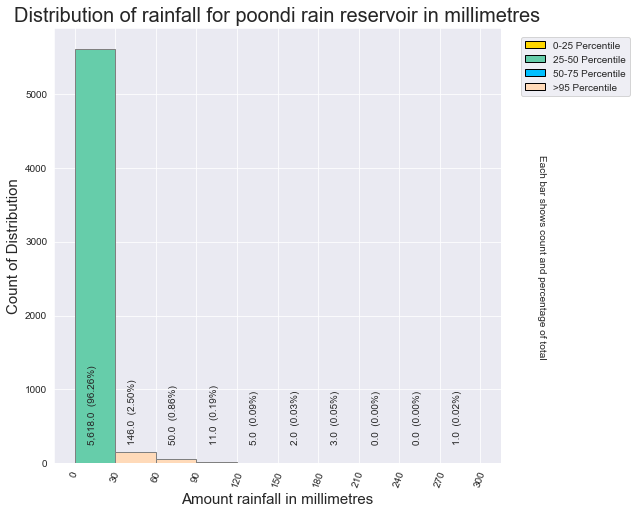

In [66]:
graph_percentile(df["poondi_rain"])


As can be seen, most of the values are zero values followed by smaller and smaller amounts of progressively higher values, with a handful of values being over 142 millimeters.

This begs the question of how these values are distributed across the years.

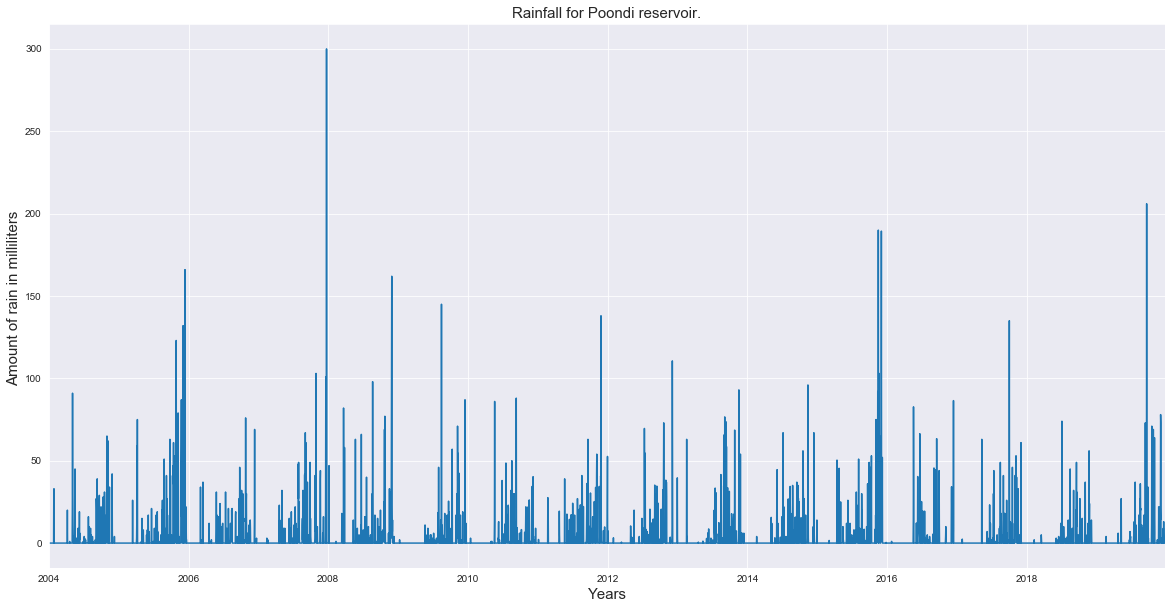

In [69]:
plot_line(df,"poondi_rain", "Years", "Amount of rain in milliliters ", "Rainfall for Poondi reservoir.")

Over here we can see that the rainfall is represented by sharp peaks and flat lines. A good portion of the year has little to no rain followed by a large amount of rain over a repeated specific amount of time.

This trend is made clearer when we look at an individual years.

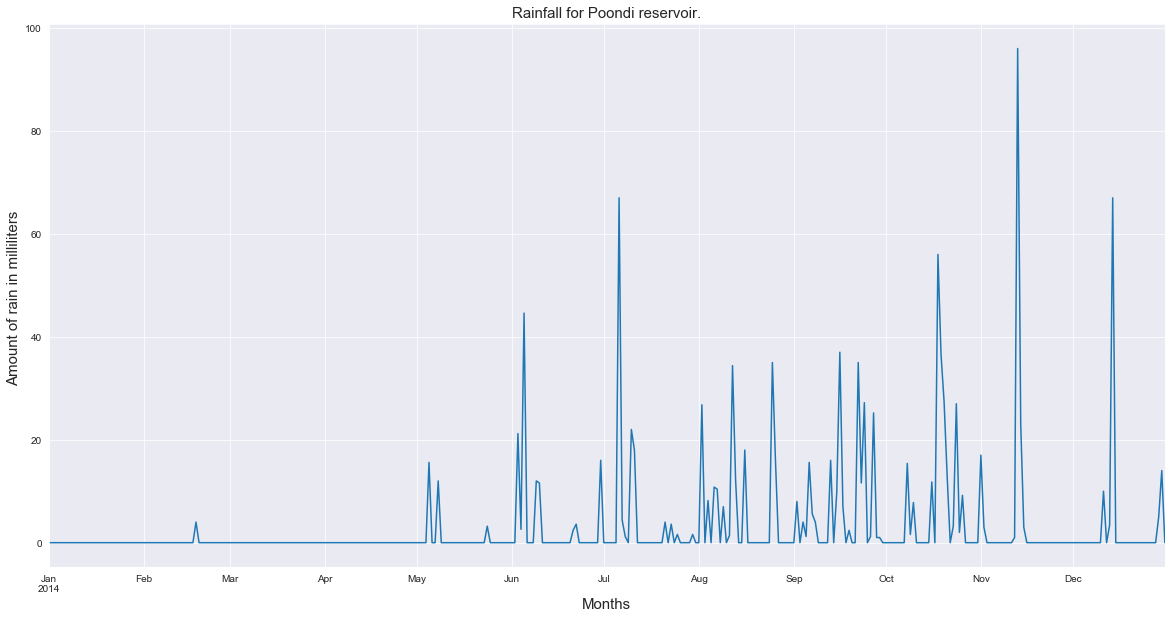

In [70]:
plot_line(df.loc['2014'],"poondi_rain", "Months", "Amount of rain in milliliters ", "Rainfall for Poondi reservoir.")

Looking at the daily rains for 2014, we see that it rains in the month of June, July, August and September. This is due to south west monsoon.            
Major rainfall also happens during October and November of every year which is due to North-east monsoon. 

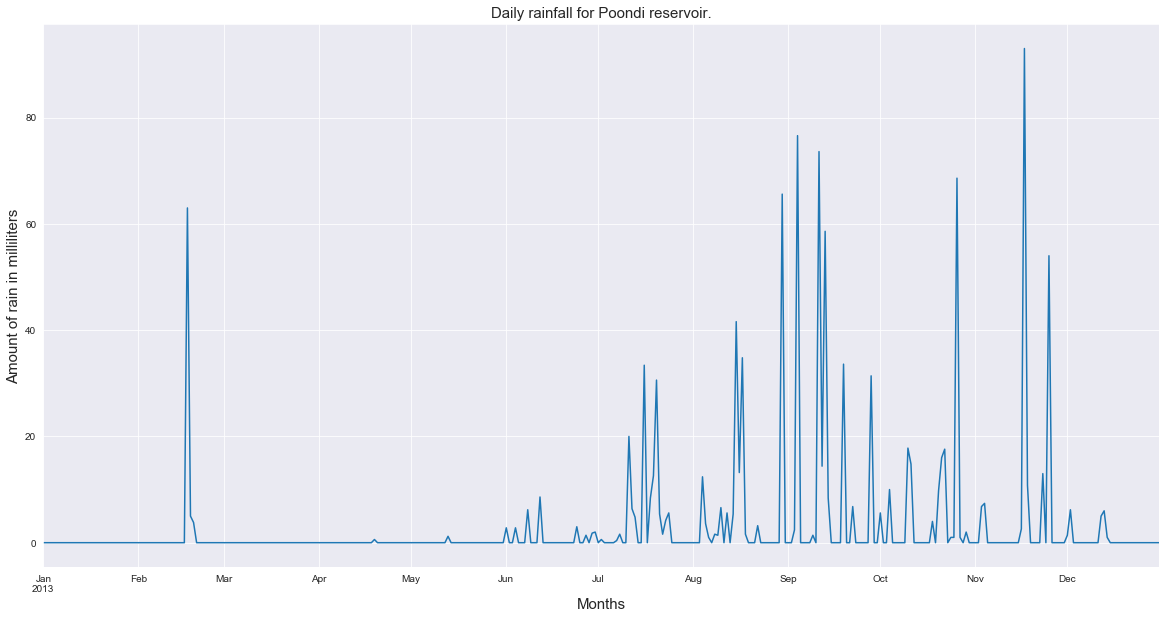

In [71]:
plot_line(df.loc['2013'],"poondi_rain", "Months", "Amount of rain in milliliters", "Daily rainfall for Poondi reservoir.")

Looking at the daily rains for 2013, we see similar findings.

All these findings make sense as India only gets on average rainfall for 54 days out of the year. The time that it does get rain it comes in the form of 2 monsoons.

This isn't to say that every year is the same. Looking at the first graph one can see that there is a massive spike in 2015. This corresponds to the massive floods that occurred throughout November and December in Chennai.

---

Moving on, we will now look at the target feature in our data the water level of the reservoir.


The appears to a lot of zero values but not nearly as many as with the rainfall values. Also, the most frequent values are low values between 0 and 500. The distribution isn't normal with a skew to the right. The average is about 1100 and a max and min of 3000 and 0 respectively.

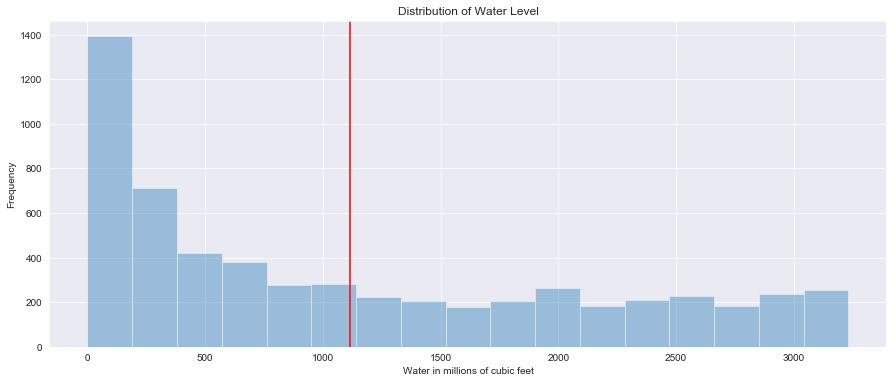

In [72]:
hist_plot(df, "poondi_water", "Water in millions of cubic feet","Frequency","Distribution of Water Level")


For our problem statement, we are trying to predict the average monthly water level in each reservoir so we are going to resample  our data to the average monthly total.

In [73]:
df_m= df.resample("m").mean()

In [74]:
df_m.describe()

,poondi_water,poondi_rain
count,192.000000,192.000000
mean,1118.908370,3.457630
std,1007.616869,4.100004
min,2.464516,0.000000
25%,239.104167,0.142627
50%,775.390860,2.358065
75%,1935.640860,5.460215
max,3225.870968,28.923333


We now have a data frame consisting of an average for rain and water level for 192 months.

Most notably the percentiles in the rain column are now not zero.

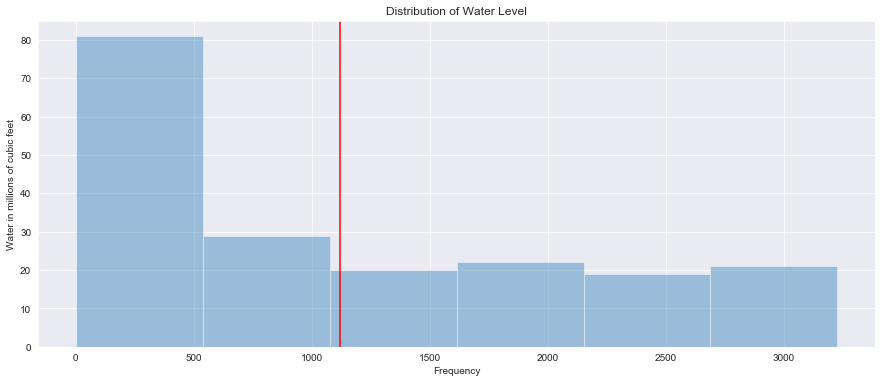

In [75]:
hist_plot(df_m, "poondi_water", "Frequency", "Water in millions of cubic feet","Distribution of Water Level")

The graph looks similar as before which makes sense as this is showing an average sum and fairly consistent with our non-resampled data.

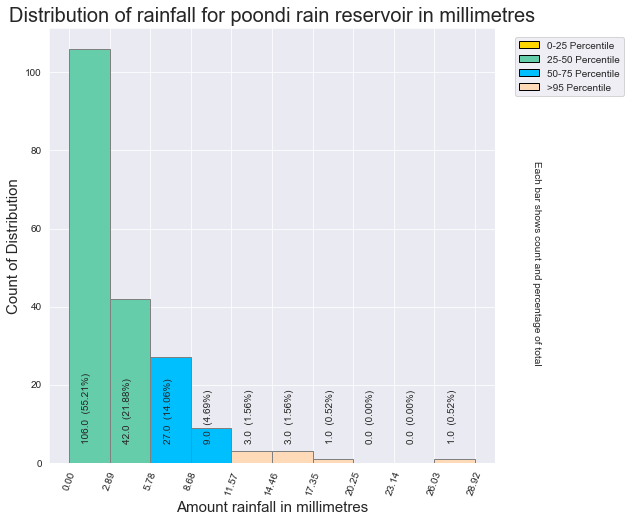

In [76]:
graph_percentile(df_m["poondi_rain"])

However, by the graph for the rain, there is a great change as now we are looking at the monthly average and not daily, so the 1 day where there was a massive outpour is more spread out.  

---

Now we are going to look at are monthly data.

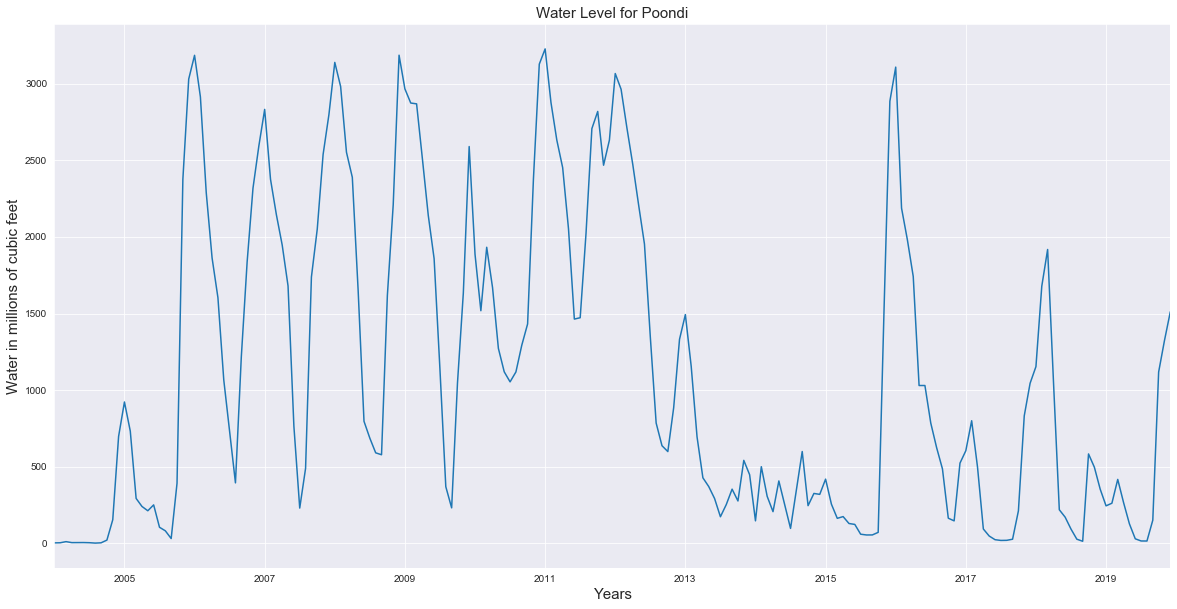

In [77]:
plot_line(df_m,"poondi_water", "Years", 
          "Water in millions of cubic feet",
          "Water Level for Poondi" )

Looking at the graph we can see several spikes above and below the average of 1300 cubic million feet.

Notable outliers include the times where the water level was zero or near zero in 2004, 2005, and most recently in 2019.

---

We are now going to look at the year of the water crisis, 2019.

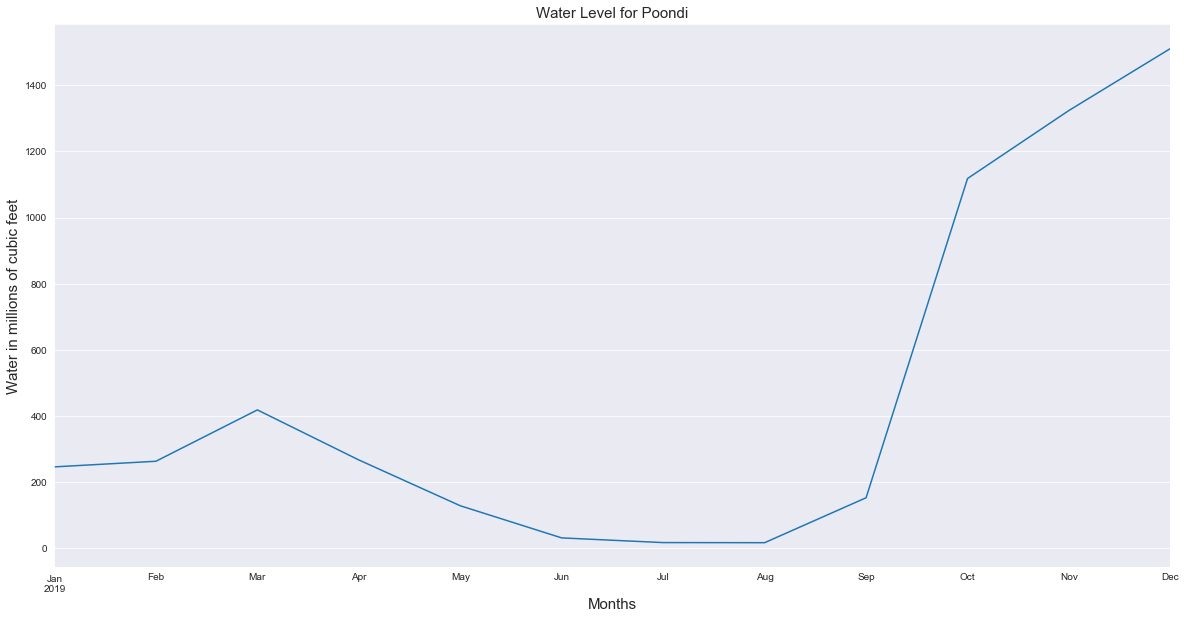

In [78]:
plot_line(df_m.loc["2019"],"poondi_water", "Months", 
          "Water in millions of cubic feet",
          "Water Level for Poondi") 

We can see that the water level was very low with the year starting at below 100 and flatting out to around 0 towards the end of April. The water level than rose toward the end of the year.

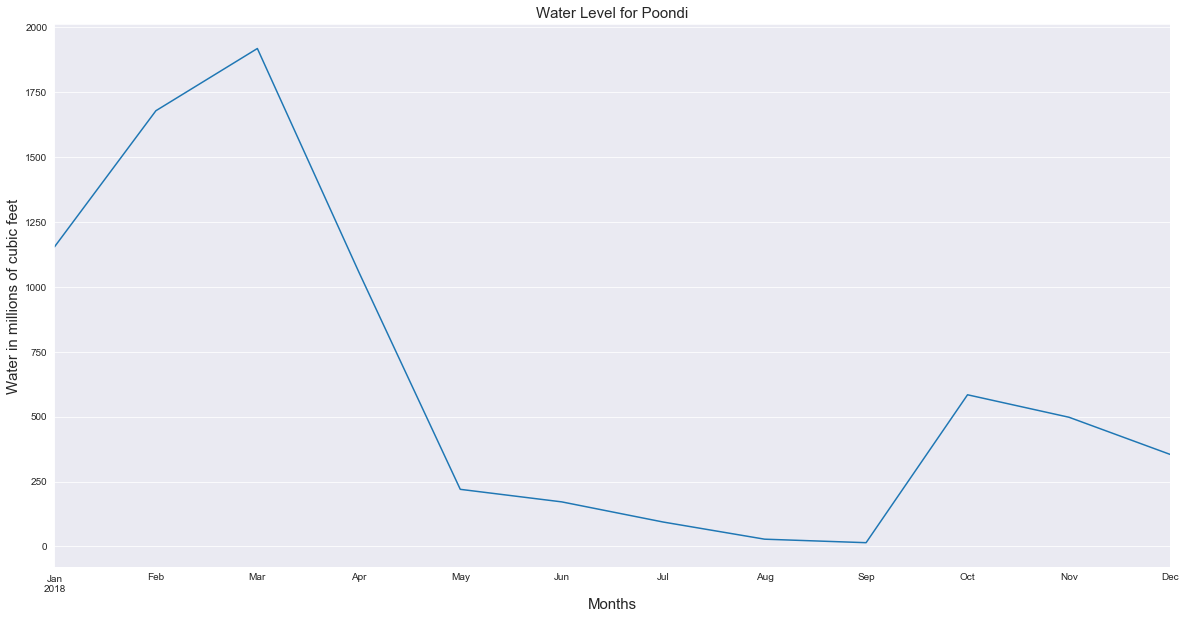

In [79]:
plot_line(df_m.loc["2018"],"poondi_water", "Months", 
          "Water in millions of cubic feet",
          "Water Level for Poondi") 

The previous year of 2018 started lower than dropped until May and than after a brief gain plummeted exponentially for the rest of the year.

If we look at the rainfall we can see that it corresponds with the rise and fall of the water level.

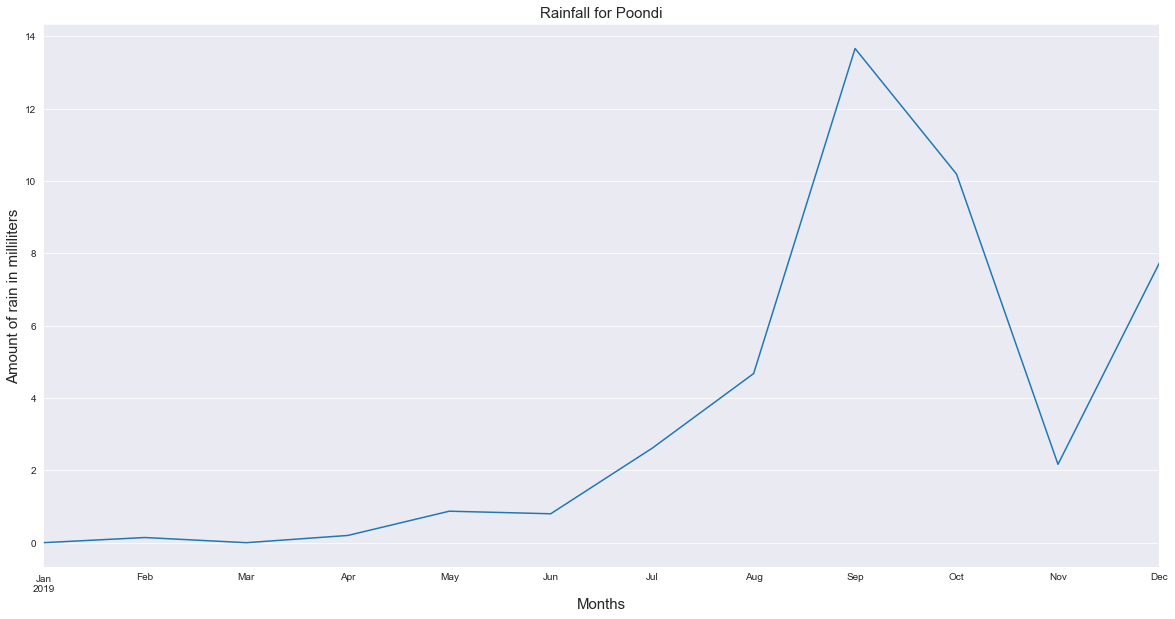

In [80]:
plot_line(df_m.loc["2019"],"poondi_rain", "Months", 
          "Amount of rain in milliliters",
          "Rainfall for Poondi") 

The rainfall is flatlined at zero and only really rises after May. The hard rainfall in October contributed to the water level rising later that year.

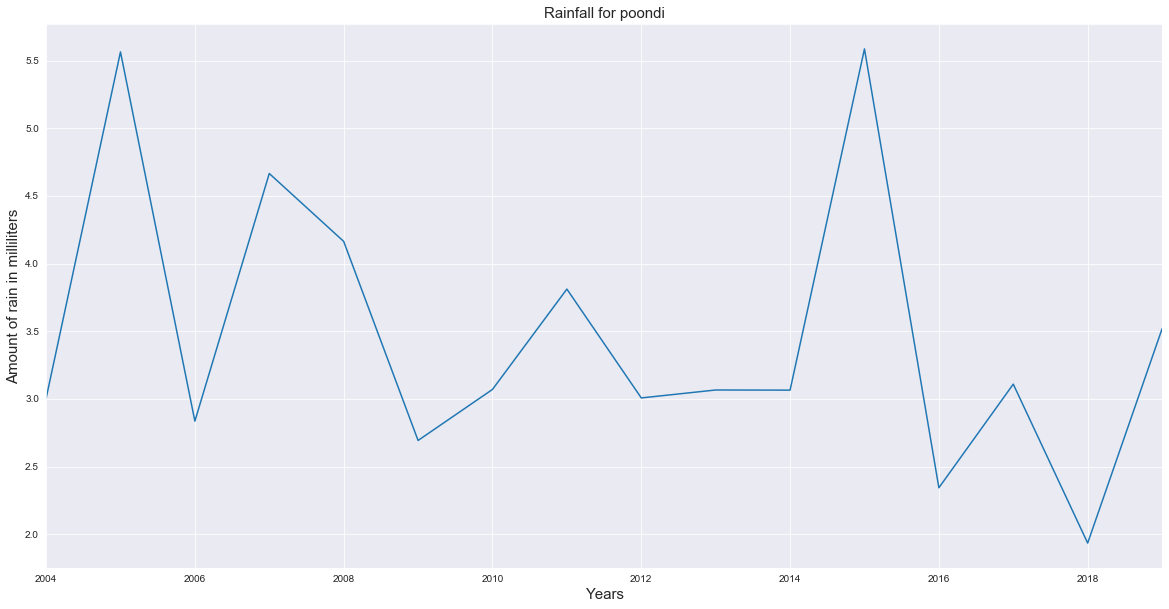

In [81]:
plot_line(df.resample("y").mean(),"poondi_rain", "Years", 
          "Amount of rain in milliliters",
          "Rainfall for poondi") 

In [24]:
pop = pd.read_csv("../data/csvData.csv")

In [25]:
pop["Year"] = pop["Year"].values[::-1]
pop["Population"] = pop["Population"].values[::-1]
pop["Growth_rate"] = pop["GrowthRate"].values[::-1]
pop["Growth"] = pop["Growth"].values[::-1]

In [26]:
pop.drop(columns=["Growth"],inplace = True)

In [27]:
pop.set_index("Year", inplace= True)

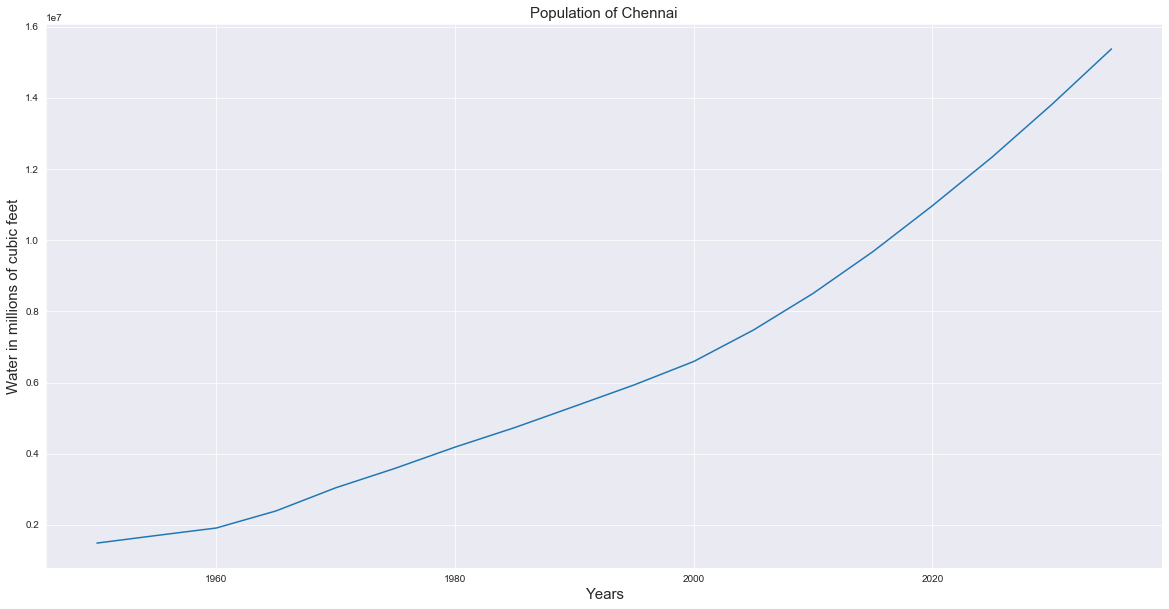

In [126]:
plot_line(pop,"Population", "Years", 
          "Water in millions of cubic feet",
          "Population of Chennai") 

<img src="../assets/ch.gif" width="500px">
<img src="../assets/CHennaiGIF.gif" width="500px">


After going through the data we can see the following:

* The city gets some rains in the month of June, July, August and September due to south west monsoon.  

* Major rainfall happens during October and November of every year which is due to North-east monsoon.  
* During the initial years rain from north-east monsoon is much higher than south-west monsoon. But seems like in the last few years, they both are similar.


---

### Engineering features

We want to predict the monthly average of the water level of a reservoir. To do this we are lagging the data.

For example, lagging the data one would correspond to the water level a month ago from the current month. So let's say if the water level for the second month was 85, A lag of one would give lag one's value 85.   
However, lag one's first value would be null  .  The reason for this is that you can't lag the data past its starting point as there is no existing data from before the start.

#### Determining Significant Lags

Over here we are goint to  use the Autocorrelation Function plot and Partial-autocorrelation plot to better visualize the shape of our time-series data and determine significant lags.

In [12]:
df_m= df.resample("M").mean()

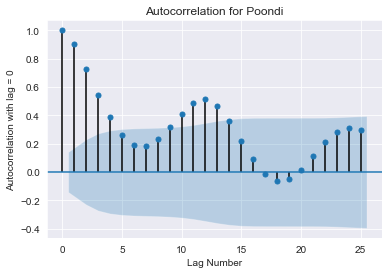

In [13]:
plot_acf(df_m['poondi_water'], lags =25)
plt.xlabel("Lag Number")
plt.ylabel("Autocorrelation with lag = 0")
plt.title("Autocorrelation for Poondi");

We see from the Autocorrelation Function plot that there is a clear pattern in our data, with it going it down as we move toward the end.

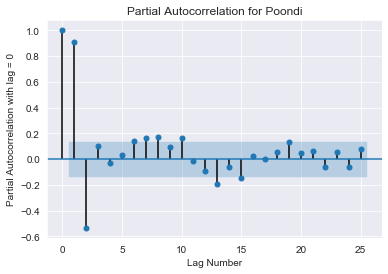

In [14]:
plot_pacf(df_m['poondi_water'], lags = 25)
plt.xlabel("Lag Number")
plt.ylabel("Partial Autocorrelation with lag = 0")
plt.title("Partial Autocorrelation for Poondi");

The Partial-autocorrelation Function plot is showing here that there are  significant lags at 1, 2, 10, 13 months respectively. We can see this based on the point bieng outside of the 95% confidence interval represented by the blue. 

In [15]:
adfuller(df_m["poondi_water"])

(-2.181849005342621,
 0.2128990487830274,
 12,
 179,
 {'1%': -3.4674201432469816,
  '5%': -2.877826051844538,
  '10%': -2.575452082332012},
 2580.7127965923783)

In [21]:
adfuller(df_m["poondi_water"].diff(1).dropna())

(-8.345484459336229,
 3.0937180095855435e-13,
 8,
 182,
 {'1%': -3.4668001583460613,
  '5%': -2.8775552336674317,
  '10%': -2.5753075498128246},
 2569.345046710506)

In [84]:
lagged_water_p = df_m.copy()

We are now lagging the data based on our findings from the graphs which showed the significant lags.

In [ ]:
df_m["poondi_water"].diff(1).dropna()

In [22]:
X = df_m.poondi_water.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history =  list(train)
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0) #
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t] 
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=140.610572, expected=98.193548
predicted=44.523731, expected=350.903226
predicted=503.352192, expected=599.700000
predicted=696.956973, expected=246.612903
predicted=31.508547, expected=326.266667
predicted=428.015848, expected=320.322581
predicted=292.142296, expected=419.580645
predicted=481.818318, expected=255.892857
predicted=154.593696, expected=163.967742
predicted=142.660168, expected=175.333333
predicted=187.820893, expected=130.258065
predicted=103.850354, expected=124.300000
predicted=128.708428, expected=60.451613
predicted=25.864705, expected=55.419355
predicted=62.020438, expected=55.666667
predicted=54.347507, expected=72.483871
predicted=82.024560, expected=1520.500000
predicted=2292.501085, expected=2884.451613
predicted=3444.669258, expected=3107.096774
predicted=3086.622256, expected=2187.172414
predicted=1688.555215, expected=1980.387097
predicted=2037.405979, expected=1741.466667
predicted=1603.028842, expected=1030.322581
predicted=685.288357, expected=1

In [85]:

lagged_water_p['poondi_water_1'] = lagged_water_p['poondi_water'].shift(1)
lagged_water_p['poondi_water_2'] = lagged_water_p['poondi_water'].shift(2)
lagged_water_p['poondi_water_10'] = lagged_water_p['poondi_water'].shift(10)
lagged_water_p['poondi_water_13'] = lagged_water_p['poondi_water'].shift(13)


In [94]:
lagged_water_p.dropna(inplace= True)

In [95]:
lagged_water_chem

,chembarambakkam_water,chembarambakkam_rain,chembarambakkam_water_1,chembarambakkam_water_2,chembarambakkam_water_10,chembarambakkam_water_13,chembarambakkam_water_23,chembarambakkam_water_24,chembarambakkam_water_25,time
date,,,,,,,,,,
2006-02-28,2737.428571,0.000000,2946.451613,2934.193548,151.600000,425.322581,0.000000,0.000000,0.000000,0
2006-03-31,2536.903226,0.193548,2737.428571,2946.451613,100.322581,243.107143,0.000000,0.000000,0.000000,1
2006-04-30,2297.466667,2.033333,2536.903226,2737.428571,231.800000,172.709677,0.000000,0.000000,0.000000,2
2006-05-31,2046.677419,2.064516,2297.466667,2536.903226,17.129032,151.600000,0.000000,0.000000,0.000000,3
2006-06-30,1856.566667,4.066667,2046.677419,2297.466667,0.645161,100.322581,0.000000,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.000000,6.096774,0.000000,0.833333,291.774194,773.548387,214.233333,107.935484,72.322581,162
2019-09-30,3.733333,4.700000,0.000000,0.000000,196.533333,525.032258,303.612903,214.233333,107.935484,163
2019-10-31,20.903226,12.032258,3.733333,0.000000,141.000000,391.966667,1293.900000,303.612903,214.233333,164


In order to model we need to add one column that serves as a placeholder for our index.

This feature will act as a counter with it starting from 0 and going from 1 and adding at each interval. This allows our model to take into account the time index without directly using time. 

In [96]:
lagged_water_p["time"] = range(len(lagged_water_p))

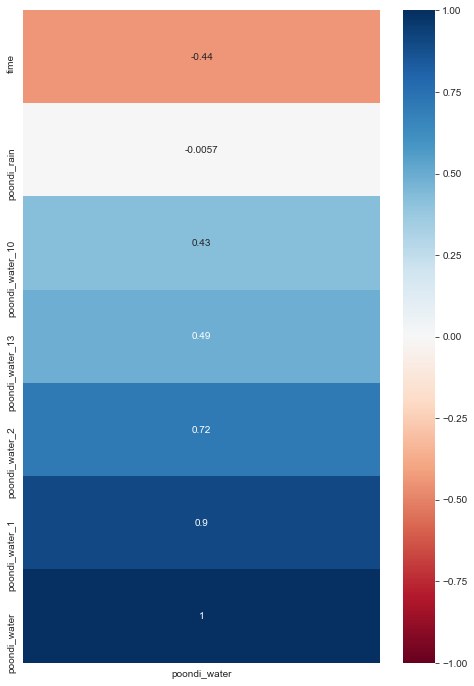

In [97]:

plt.figure(figsize = (8,12))
sns.heatmap(lagged_water_p.corr()[["poondi_water"]].sort_values('poondi_water'),
           annot=True,
           cmap="RdBu",
           vmin=-1,
           vmax = 1);

We can see that rain has .02 correlation with the water level.

In [98]:
lagged_water_p.shape

(179, 7)

We now have a data frame consisting of 167 months of data along with the lagged data.

## Model Preparation
---

In [99]:
X = lagged_water_p.drop(columns=["poondi_water","poondi_rain"])

X = sm.add_constant(X) # its nessary to add a constant for stats models

y = lagged_water_p["poondi_water"]

# we are not shuffling as this is a time-series and the order matters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .299, shuffle = False)

---

### Baseline

In [100]:
dumb = DummyRegressor(strategy='mean') # setting the strategy to guess the mean.

In [101]:
dumb.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [102]:
dumb.score(X_train, y_train)

0.0

In [103]:
dumb.score(X_test, y_test)

-1.002610731277911

**Interpretation**: We see that just predicting the mean monthly water level will explain ~0% of the variation in our target. Any model that is able to explain any variation in the target will be a vast improvement.

### Linear Regression
---

In [104]:
# instantiate
OLS = sm.OLS(y_train, X_train) 

# fit
water_ols = OLS.fit() 

In [105]:
y_train_preds = water_ols.predict(X_train)
r2_score(y_train, y_train_preds)

0.8913745707651191

The training $R2$ indicates that our X, which consists of the lagged monthly water data, can explain 92.1% of the variation of the target variable, the actual average monthly water level.

In [106]:
y_test_preds = water_ols.predict(X_test)
r2_score(y_test, y_test_preds)

0.7195739699834613

The testing $R2$ indicates that our X, which consists of the lagged monthly water data, can explain 85.9% of the variation of the target variable, the actual average monthly water level.

**Interpretation:** Our model appears to be overfitting to our training dataset with a training $R2$ score of 91.19% and a testing $R2$ of 85.91%.



The a good next step would be to employ regularization on our model as a means of increasing bias for a lower variance.

### Linear Regression Including Exogenous Variable

---

For this model, we are going to add an exogenous variable. In our model that would mean adding the rainfall feature.

In [112]:
X_r= lagged_water_p.drop(columns=["poondi_water"]) # dropping target

X_r = sm.add_constant(X_r) # its nessary to add a constant for stats models

y_r= lagged_water_p["poondi_water"] #selecting target

# we are not shuffling as this is a time series and the order matters

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size = .299, shuffle = False)


In [113]:
rain_ols = sm.OLS(y_train_r, X_train_r) 
# fitting 
rain_ols = rain_ols.fit()

In [114]:
y_train_preds_r = rain_ols.predict(X_train_r)
r2_score(y_train_r, y_train_preds_r)

0.8928697271298778

The training $R2$ indicates that our X, which consists of the lagged monthly water data and rainfall data, can explain 92.3% of the variation of the target variable, the actual average monthly water level.

In [115]:
y_test_preds_r = rain_ols.predict(X_test_r)
r2_score(y_test_r, y_test_preds_r)

0.7652510349399377

The training $R2$ indicates that our X, which consists of the lagged monthly water data and rainfall data, can explain 93% of the variation of the target variable, the actual average monthly water level.

**Interpretation**: After adding the rain column our model actually has a higher testing score than our training dataset with a training $R2$ score of 92.07% and a testing $R2$ of 93.13%.

I believe that this is not due to data leakage from the training set to the testing set, but rather due to an irregularity in the data. 

In the future, we would further like to investigate what the irregularity in the data might be.

## Model Selection

Model Name | Training Score | Testing Score
- | -| -
Chembarambakkam Baseline|0|-67%
Chembarambakkam Linear Regression| 91%  | 87%
Chembarambakkam Linear Regression with Exogenous Variable|92% |93% 

For our model evaluation, we are going to choose the linear regression model with Exogenous Variable as it scored the best $R2$.

## Model Evaluation 


I will evaluate the Linear Regression with Exogenous Variable Model by calculating the Root Mean Squared Error and by examining the residuals and looking at the Coefficients.

In [116]:
resids_train = y_train_r - y_train_preds_r 

In [117]:
resids_test = y_test_r - y_test_preds_r

In [118]:
y_test_preds_r.value_counts().sum()

54

In [119]:
rmse = np.sqrt(mean_squared_error(y_test_r, y_test_preds_r))
print(f'The RMSE is {round(rmse,2)}.')

The RMSE is 363.21.


According to the value of the RMSE, the predictions for the Average Monthly Water level by the Linear Regression Model with Exogenous Variable are likely off by about 245 million cubic feet. I would like to improve the model's predictability and try to get this number to be smaller.


### Distribution of Residuals

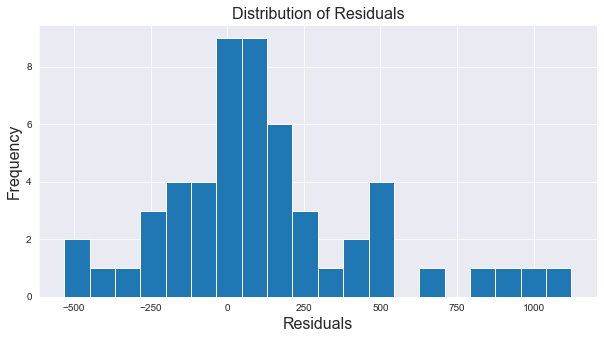

In [120]:
plt.figure(figsize=(10,5)) #determining size
plt.title('Distribution of Residuals',fontsize= 16)
plt.xlabel('Residuals',fontsize= 16)
plt.ylabel('Frequency',fontsize= 16)
plt.hist(resids_test, bins = 20);


**Interpretation**: From the above histogram, it is evident that the residuals are not normally distributed. On both tails of the distribution, there are some residuals that indicate that the model's prediction was incorrect by quite a bit. However this does not mean that our model is a bad model.

### Average Monthly Water Level Predictions compared to the actual values


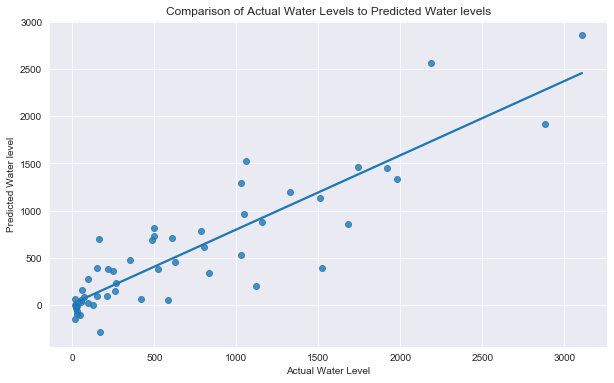

In [121]:
plt.figure(figsize=(10,6))
x = sns.regplot(x= y_test_r, y= y_test_preds_r, ci=None)
x.set(xlabel="Actual Water Level",
      ylabel= "Predicted Water level", 
      title="Comparison of Actual Water Levels to Predicted Water levels");

**Interpretation**: 
From this plot, we are able to see that this model does not perform equally well at predicting all average monthly water levels. We see that there sevaral data points clumped around zero.  

In addition, we can see that are several outliers in our testing data where the actual water level was higher than the predicted water level by about five hundred million cubic feet.

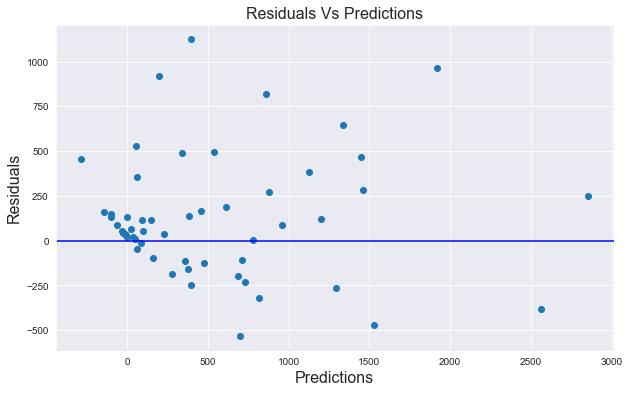

In [122]:
plt.figure(figsize=(10,6)) # determining size
plt.title("Residuals Vs Predictions",fontsize= 16) # plotting title
plt.scatter(y_test_preds_r  , resids_test);
plt.xlabel('Predictions', fontsize= 16) # plotting label
plt.ylabel('Residuals',fontsize= 16) # plotting label
plt.axhline(0, color='Blue');

**Interpretation**: We can see that the variance is fairly uniform. The residuals increase at the more extreme predicted values. The exception is by the zero where there is a v shape by the zero value.

### Looking at the coefficients

---

In [123]:
rain_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           poondi_water   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     163.9
Date:                Tue, 22 Sep 2020   Prob (F-statistic):           8.52e-55
Time:                        15:24:12   Log-Likelihood:                -902.67
No. Observations:                 125   AIC:                             1819.
Df Residuals:                     118   BIC:                             1839.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             122.0722    106.678      1.144      0.255     -89.179     333.323
poondi_rain        12.3503      9.624      1.283      0.202      -6.708      31.408
poondi_water_1      1.2321      0.077     16.020      0.000       1.080       1.384
poondi_water_2     -0.4117      0.077     -5.376      0.000      -0.563      -0.260
poondi_water_10     0.1597      0.039      4.112      0.000       0.083       0.237
poondi_water_13    -0.0278      0.047     -0.596      0.552      -0.120       0.065
time               -1.6166      0.969     -1.668      0.098      -3.535       0.302
==============================================================================
Omnibus:                       21.379   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.615
Skew:                           0.675   Prob(JB):                     7.55e-11
Kurtosis:                       5.670   Cond. No.                     1.14e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking at the lags we see that given a p value of less than .05 being significant lag 1, 2, and 24 are significant.

The way that we would interpret the lags would be as follows:  
* With all held constant a 1 million cubic feet increase for one month prior, would predict a 1.32 cubic million increase for the target month.
* With all held constant a 1 million cubic feet increase for two months prior, would predict a 0.48 cubic million decrease for the target month.
* With all held constant a 1 million cubic feet increase for 24 months prior, would predict a 0.28 cubic million increase for the target month.


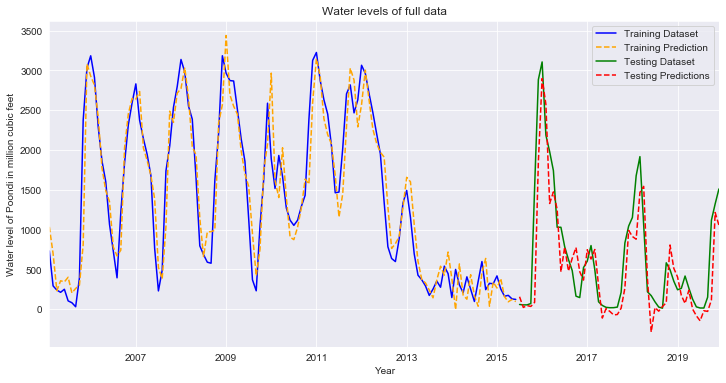

In [125]:
plt.figure(figsize=(12,6)) #d

plt.title("Water levels of full data")

y_train.plot(style="b")
y_train_preds.plot(style="orange", linestyle = "--") # orange with dash
y_test.plot(style="g")
y_test_preds.plot(style="r--") # red with dash
plt.xlabel("Year")
plt.ylabel("Water level of Poondi in million cubic feet")
plt.legend(labels = ["Training Dataset", "Training Prediction", "Testing Dataset", "Testing Predictions"]);

For final thoughts and conclusions refer back to main notebook.